# 決定木とランダムフォレスト（Random Forests）

原作者のJoseさんのブログをまずはご覧ください。
[こちら](https://medium.com/@josemarcialportilla/enchanted-random-forest-b08d418cb411)


Pythonをつかって、決定木とランダムフォレストの世界を探検してみましょう。

In [1]:
#Imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## ランダムフォレスト分類器

ランダムフォレスト（Random forests）は、アンサンブル学習法の一つです。アンサンブル学習法は、いくつかの分類器を集めて構成されるものですが、ここでは決定木が使われます。（木が集まるから森というわけです）

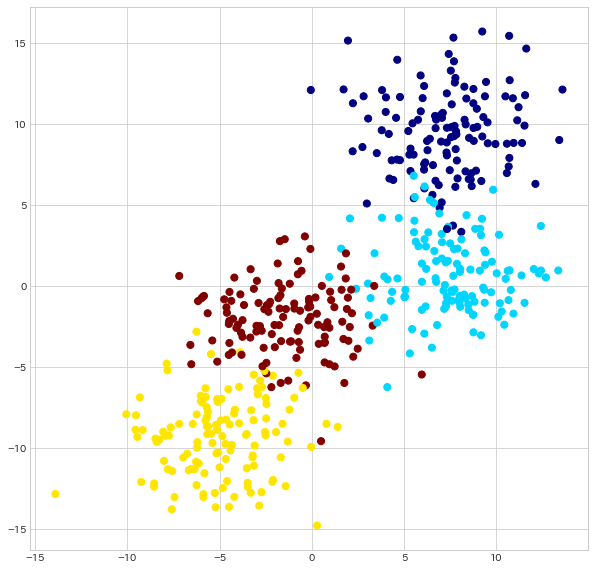

In [2]:
# 架空のデータを用意します。
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=500, centers=4,
                  random_state=8, cluster_std=2.4)

#Scatter plot the points
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')

In [3]:
from sklearn.tree import DecisionTreeClassifier

### 描画のための関数

In [4]:
def visualize_tree(classifier, X, y, boundaries=True,xlim=None, ylim=None):
    '''
    決定木の可視化をします。
    INPUTS: 分類モデル, X, y, optional x/y limits.
    OUTPUTS: Meshgridを使った決定木の可視化
    '''
    # fitを使ったモデルの構築
    classifier.fit(X, y)
    
    # 軸を自動調整
    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    
    
    # meshgridをつくります。
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # 分類器の予測をZとして保存
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # meshgridを使って、整形します。
    Z = Z.reshape(xx.shape)
    
    # 分類ごとに色を付けます。
    plt.figure(figsize=(10,10))
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='jet')
    
    # 訓練データも描画します。
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet', alpha=0.5)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    
    def plot_boundaries(i, xlim, ylim):
        '''
        境界線を描き込みます。
        '''
        if i < 0:
            return

        tree = classifier.tree_
        
        # 境界を描画するために、再帰的に呼び出します。
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
    
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

深さ2までのプロットを描いて見ます。

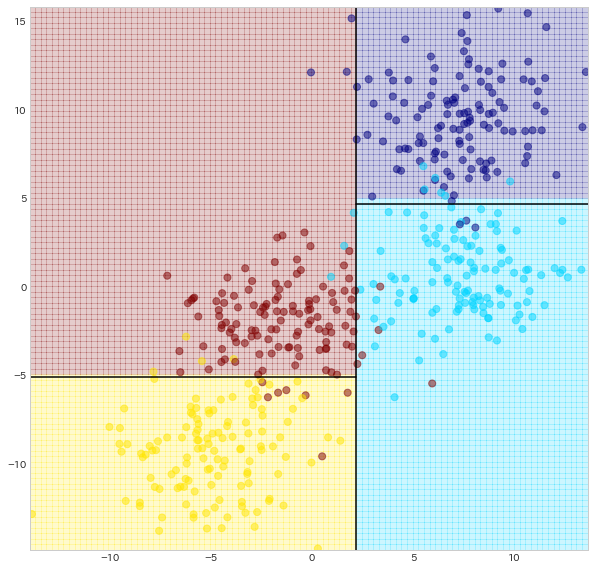

In [5]:
# モデルを作ります。
clf = DecisionTreeClassifier(max_depth=2,random_state=0) # max_depth : 木の深さ

# 描画します。
visualize_tree(clf,X,y)

** 深さを4にしてみます**

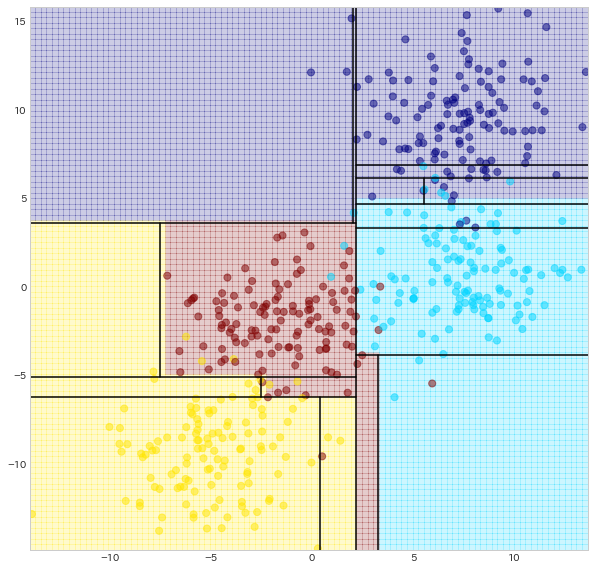

In [6]:
clf = DecisionTreeClassifier(max_depth=4, random_state=0)

visualize_tree(clf,X,y)

あまりにも細かく分類すると、過学習（over fitting）の問題が起こります。

## Random Forests

過学習の問題を回避するための一つの方法が、ランダムフォレストです。

ランダムフォレストは、学習データの一部をランダムに選んで、決定木を作ります。これを繰り返すことによって、色々な種類の木が出来るので、汎化性能が下がるのを避けることが出来るわけです。

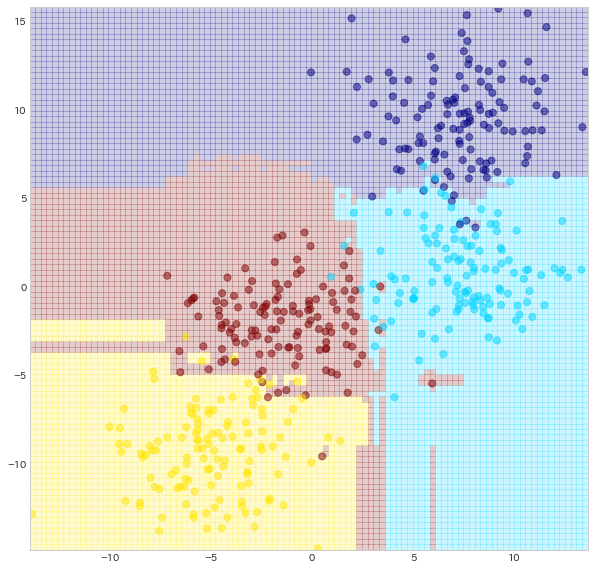

In [7]:
from sklearn.ensemble import RandomForestClassifier

# n_estimatorsは、作る木の数です。
clf = RandomForestClassifier(n_estimators=100,random_state=0)

# 境界線を書かないようにします。
visualize_tree(clf,X,y,boundaries=False)

決定木とは違った境界線が描かれているのがわかります。

## Random Forest Regression
ランダムフォレストは、分類だけではなく、回帰にも使うことができます。

ダミーのデータを作って、試してみましょう。

<Container object of 3 artists>

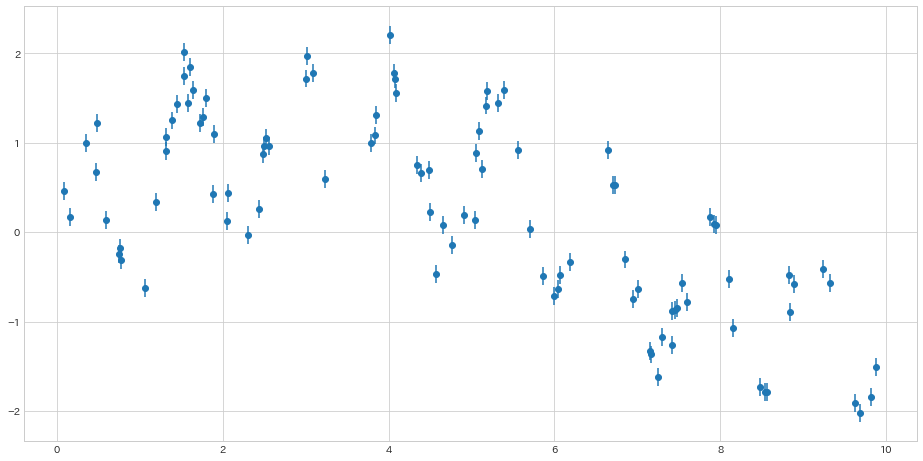

In [8]:
from sklearn.ensemble import RandomForestRegressor

x = 10 * np.random.rand(100)

def sin_model(x, sigma=0.2):
    '''
    大きな波＋小さな波＋ノイズからなるダミーデータです。
    '''
   
    noise = sigma * np.random.randn(len(x))

    return np.sin(5 * x) + np.sin(0.5 * x) + noise

# xからyを計算
y = sin_model(x)

# Plotします。
plt.figure(figsize=(16,8))
plt.errorbar(x, y, 0.1, fmt='o')

このデータを単純な線形回帰で予測しようとしても難しいのは、一目瞭然です。
そこで、ランダムフォレストを使って見ることにしましょう。

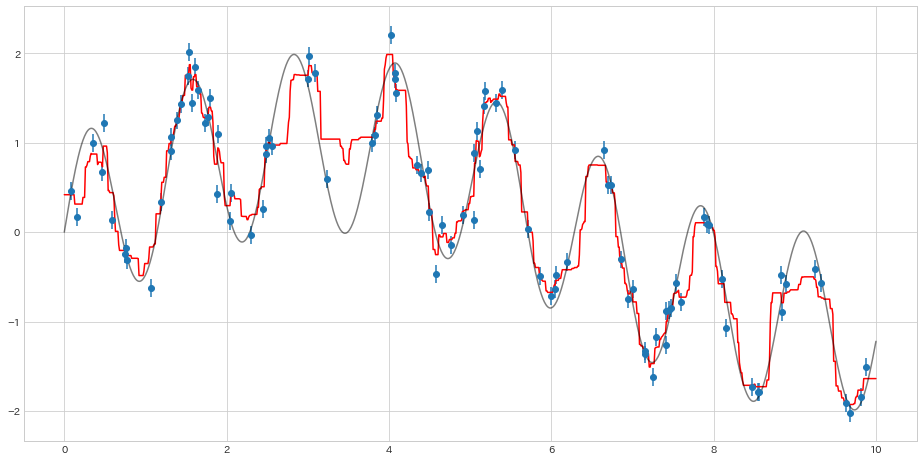

In [9]:
# X を用意します。
xfit = np.linspace(0, 10, 1000)

# 回帰モデルを用意します。
rfr = RandomForestRegressor(100)

# モデルを学習させます。
rfr.fit(x[:, None], y) # x[:, None] は x[:, np.newaxis], x.reshape(-1, 1) と同じ

# 予測値を計算します。
yfit = rfr.predict(xfit[:, None])

# 実際の値です。
ytrue = sin_model(xfit, 0)

# Plot します
plt.figure(figsize=(16,8))

plt.errorbar(x, y, 0.1, fmt='o')

plt.plot(xfit, yfit, '-r'); # '-r' は( c='r', linestyle='-' ) をまとめて書いたもの
plt.plot(xfit, ytrue, '-k', alpha=0.5);

ランダムフォレストは、このように分類だけでは無く、回帰にも使えるので、非常に応用範囲が広い方法論です。

In [10]:
xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

x_min, x_max = xlim
y_min, y_max = ylim


# meshgridをつくります。
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# 分類器の予測をZとして保存
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# meshgridを使って、整形します。
Z = Z.reshape(xx.shape)

NameError: name 'classifier' is not defined

In [ ]:
np.c_[xx.ravel(), yy.ravel()]

In [ ]:
xx.ravel()

In [ ]:
yy.ravel()

In [ ]:
a = np.arange(3)
b = np.arange(4, 7, 1)
aa, bb = np.meshgrid(a, b)

In [ ]:
aa

In [ ]:
bb

In [ ]:
np.c_[aa.ravel(), bb.ravel()]

In [ ]:
import sklearn
sklearn.__version__

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()

In [ ]:
X = iris.data

In [ ]:
y = iris.target

In [ ]:
clf = DecisionTreeClassifier(max_depth=2) # max_depth : 木の深さ

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
predicted = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predicted)

In [ ]:
y_test

In [ ]:
predicted

In [ ]:
visualize_tree(clf,X_train,y_train)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
visualize_tree(clf,X_train,y_train)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='Accent')

In [ ]:
clf.predict

In [ ]:
X_test[5]